### Creating bathymetry for Lake Geneva 

In [1]:
import sys
import os
import glob

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.interpolate import griddata

In [2]:
# Get the path to the parent folder (one level up)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(parent_folder)

# Add the parent folder to sys.path
sys.path.append(parent_folder)

import json
from configs.config_object import ConfigObject

C:\Users\rasmusso\Desktop\preprocessing-mitgcm\Zurich


In [3]:
config = ConfigObject( '../../Zurich/configs/config.json')

In [4]:
# loading swiss topo files first (resolution is 1km)
path_swisstopo = config.paths.swiss_topo_path
files_topo = glob.glob(os.path.join(path_swisstopo, '*.asc'))

In [5]:
# loading x and y files 
grid_folder_path = config.paths.grid_folder_path

with open(os.path.join(grid_folder_path, 'x_sg_grid.npy'), 'rb') as f:
    x = np.load(f)

with open(os.path.join(grid_folder_path, 'y_sg_grid.npy'), 'rb') as f:
    y = np.load(f)

In [6]:
def extract_topo(filename):
    
    # get out variables 
    ncols = None
    nrows = None
    xcorner = None
    ycorner  = None
    cellsize = None
    flag = None 
    
    # Read the file and extract ncols and nrows
    with open(filename, 'r') as file:
        
        for i in range(6):
            line = file.readline()
            
            if line.startswith('ncols'):
                ncols = int(line.split()[1])
                print(ncols)
            elif line.startswith('nrows'):
                nrows = int(line.split()[1])
                print(nrows)
            elif line.startswith('xllcorner'):
                xcorner = int(line.split()[1])
            elif line.startswith('yllcorner'):
                ycorner = int(line.split()[1])
            elif line.startswith('cellsize'):
                cellsize = int(line.split()[1])
            elif line.startswith('nodata_value'):
                flag = int(line.split()[1])
    
    # swiss coordinates for the whole section 
    xsc = np.arange(xcorner, (xcorner + (ncols*cellsize)), cellsize)
    ysc = np.arange(ycorner, (ycorner + (nrows*cellsize)), cellsize)

    
    # extract data (skipping first 6 rows)
    data_topo = np.loadtxt(filename, skiprows=6)
    data_topo = np.flip(data_topo, axis=0) #need to flip because somewhere along the way something is funky
    
    # Replace values of -999 with NaN
    data_topo[data_topo == flag] = np.nan
    
    # creating xarray 

    #swiss coordinates
    topo = xr.DataArray(
        data_topo,
        coords=[ysc, xsc],
        dims=['ysc', 'xsc'],)

    
    return (topo)        

Extract and concatenate files from Swiss topo

In [7]:
# loading swiss topo files first (resolution is 1km)
all_topo = []

for file in files_topo:
    topo = extract_topo(file)
    all_topo.append(topo)

all_topo = xr.combine_by_coords(all_topo)

10504
6386


In [8]:
all_topo

<xarray.DataArray (ysc: 6386, xsc: 10504)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * ysc      (ysc) int32 227658 227661 227664 227667 ... 246807 246810 246813
  * xsc      (xsc) int32 682839 682842 682845 682848 ... 714342 714345 714348

In [9]:
all_topo.isel(xsc=0, ysc=0).values

array(nan)

### transform coordinates from ch1903+ to ch1903
all_topo['xsc'] = all_topo['xsc'] - 2000000
all_topo['ysc'] = all_topo['ysc'] - 1000000

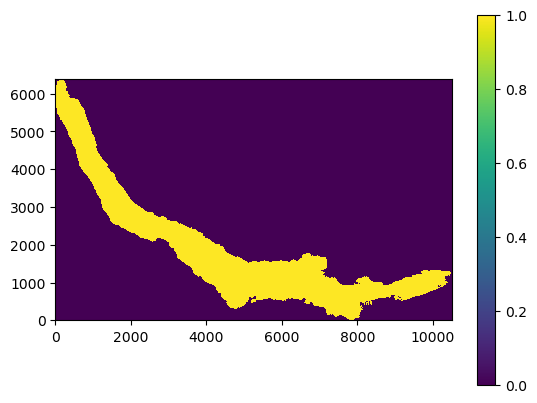

In [10]:
mask = ~np.isnan(all_topo.values)
#mask = all_topo.values < 406 
plt.imshow(mask, cmap='viridis', interpolation='nearest', origin='lower')

# Add a color bar to show the scale of values
plt.colorbar()

# Display the plot
plt.show()

In [11]:
# get max elevation 
all_topo.where(all_topo == all_topo.max(), drop=True).values

array([[406.11]])

#### Interpolate grid

### grid values

In [12]:
x_topo, y_topo = np.meshgrid(all_topo.xsc.values,all_topo.ysc.values)
values_topo = all_topo.values.flatten()

topo_grid_interp = griddata((x_topo.flatten(), y_topo.flatten()), values_topo, (x.flatten(), y.flatten()), method='nearest')

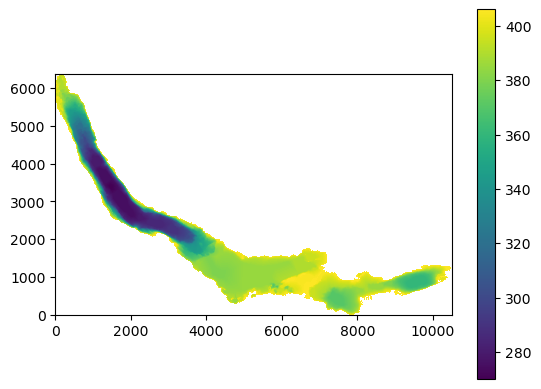

In [13]:
plt.imshow(all_topo.values, cmap='viridis', interpolation='nearest', origin='lower')

# Add a color bar to show the scale of values
plt.colorbar()

# Display the plot
plt.show()

In [14]:
xr_topo_grid_interp = xr.DataArray(
        topo_grid_interp.reshape(x.shape),
        coords= {'xsc': np.arange(x.shape[1]), 'ysc':np.arange(x.shape[0])},
        dims=['ysc', 'xsc'],)

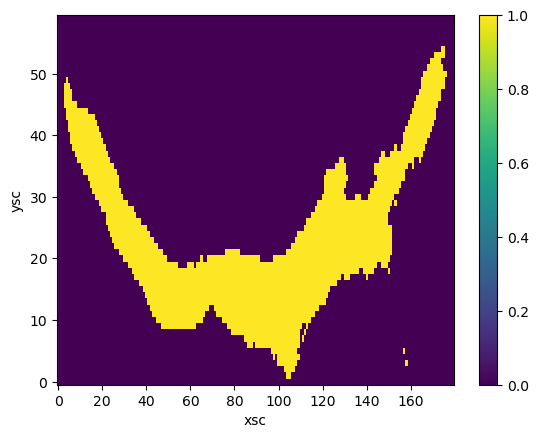

In [15]:
mask = ~np.isnan(xr_topo_grid_interp)
mask.plot()

In [16]:
xr_bathy_grid_interp = xr_topo_grid_interp - config.lake_altitude

In [17]:
clean_bathy_grid_interp = xr_bathy_grid_interp.where(mask == True, 2)

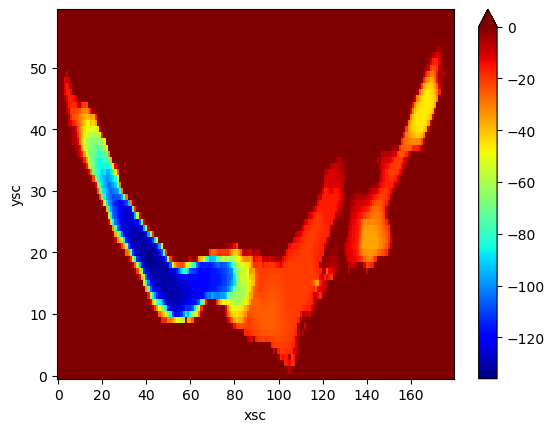

In [18]:
clean_bathy_grid_interp.plot(vmax=0, cmap='jet')

In [19]:
clean_bathy_grid_interp

<xarray.DataArray (ysc: 60, xsc: 180)>
array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])
Coordinates:
  * xsc      (xsc) int32 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179
  * ysc      (ysc) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

### Setting zeros to something positive (that is setting non-water to land)

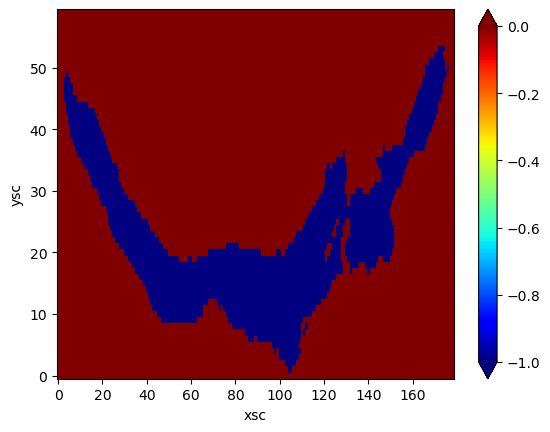

In [20]:
bathy_grid_filled = clean_bathy_grid_interp.where(clean_bathy_grid_interp <= -1 , other=2)
bathy_grid_filled.sel(xsc = np.arange(179)).plot(vmin = -1, vmax=0, cmap='jet')

### Display transects for verification

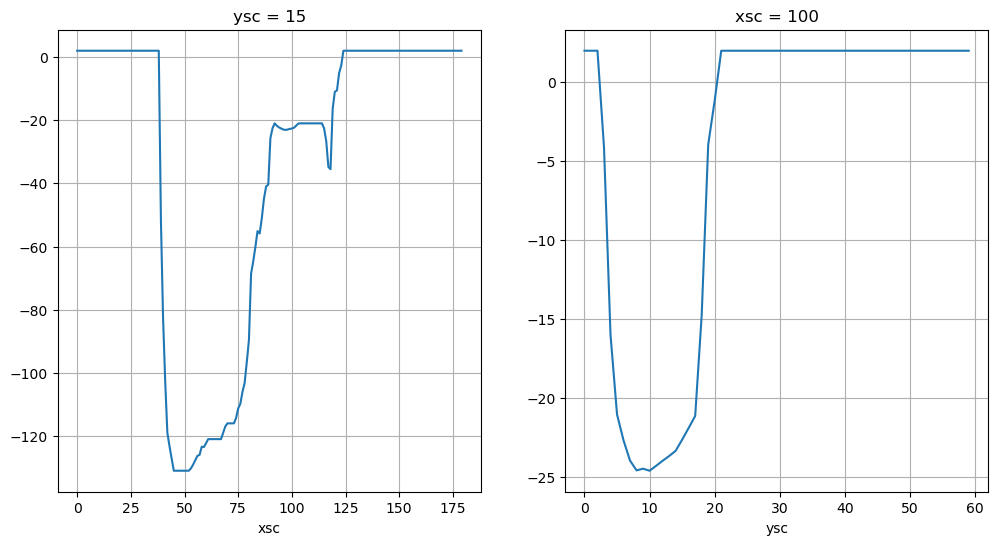

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bathy_grid_filled.sel(ysc=15,method='nearest').plot(ax=ax1)
ax1.grid()

bathy_grid_filled.sel(xsc=100,method='nearest').plot(ax=ax2)
ax2.grid()

In [22]:
# saving bathy file 

def write_binary(path_fname: str,data: xr.DataArray, dtype: str):
    '''
    Saves data in the right binary format for MITgcm, in the dimension order XYT
    Output binary files have been read and tested 
    '''

    data = data.to_numpy() #convert to xarray to numpy first - and then save to binary
    data = data.astype(dtype)

    # Write to file
    fid = open(path_fname, 'wb')
    data.tofile(fid)
    fid.close()

    
#bathy_grid_filled = bathy_grid_filled.transpose('xsc','ysc')
write_binary(os.path.join(config.paths.grid_folder_path, f'bathy_{config.grid_config_name}.bin'),bathy_grid_filled, '>f8') # big-endian and precision 64
#write_binary(os.path.join(config.paths.grid_folder_path, f'bathy_{config.grid_config_name}_little_endian.bin'),bathy_grid_filled, '<f8') # little-endian and precision 64